In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# btc_file = '../knn/Bitcoin_01.10.2017-20.03.2025_historical_data_coinmarketcap.csv'
btc_file = '../Bitcoin_data/All_together.csv'

df_btc = pd.read_csv(btc_file, sep=';')

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_df = df_btc.copy()

In [3]:
columns_to_drop = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow']
for col in columns_to_drop:
    if col in scaled_df.columns:
        scaled_df.drop(columns=[col], inplace=True)

if 'timestamp' in scaled_df.columns:
    scaled_df = scaled_df.set_index('timestamp')

feature_columns = ['open', 'high', 'low', 'volume', 'marketCap']
target_column = 'close'

available_feature_cols = [col for col in feature_columns if col in scaled_df.columns]
print(f"Доступні колонки для features: {available_feature_cols}")

if target_column not in scaled_df.columns:
    print(f"Помилка: колонка '{target_column}' не знайдена!")
    exit()

scaled_df[available_feature_cols] = feature_scaler.fit_transform(scaled_df[available_feature_cols])
scaled_df[[target_column]] = target_scaler.fit_transform(scaled_df[[target_column]])

print("Структура даних:")
print(scaled_df.head())
print(f"Shape: {scaled_df.shape}")

Доступні колонки для features: ['open', 'high', 'low', 'volume', 'marketCap']
Структура даних:
           name  open  high  low  close  volume  marketCap
timestamp                                                 
NaN         NaN   NaN   NaN  NaN    NaN     NaN        NaN
NaN         NaN   NaN   NaN  NaN    NaN     NaN        NaN
NaN         NaN   NaN   NaN  NaN    NaN     NaN        NaN
NaN         NaN   NaN   NaN  NaN    NaN     NaN        NaN
NaN         NaN   NaN   NaN  NaN    NaN     NaN        NaN
Shape: (4399, 7)


In [4]:
def prepare_data(df, window_size=5):
    X, y = [], []
    feature_cols = [col for col in df.columns if col != 'close']
    
    for i in range(len(df) - window_size):
        features = df[feature_cols].iloc[i:i+window_size].values
        target = df['close'].iloc[i+window_size]
        
        X.append(features.flatten())
        y.append(target)
    
    return np.array(X), np.array(y)


In [5]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2=None, dropout_rate=0.2):
        super(MLPModel, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_size, hidden_size1))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        if hidden_size2:
            layers.append(nn.Linear(hidden_size1, hidden_size2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(hidden_size2, 1))
        else:
            layers.append(nn.Linear(hidden_size1, 1))
            
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
def run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                             target_scaler, results_dict, epochs=100, lr=0.001):
    print(f"Training {model_name}...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    
    model = model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy()
    
    preds_inv = target_scaler.inverse_transform(preds)
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)
    
    results_dict[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'final_loss': train_losses[-1],
        'model': model,  
        'X_test': X_test,
        'y_test': y_test
    }
    
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print("-" * 50)
    
    return model

In [7]:
results = {}

window_sizes = [5, 10, 15]
hidden_sizes = [(64,), (128,), (64, 32), (128, 64), (256, 128)]
learning_rates = [0.001, 0.01]
epochs_list = [50, 100, 1000]

best_X_test, best_y_test = None, None

print("Початок експериментів з MLP моделями")
print("=" * 60)

experiment_count = 0
total_experiments = len(window_sizes) * len(hidden_sizes) * len(learning_rates) * len(epochs_list)


Початок експериментів з MLP моделями


In [8]:
for window_size in window_sizes:
    print(f"\n Window size: {window_size}")
    
    X, y = prepare_data(scaled_df, window_size=window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    
    best_X_test, best_y_test = X_test, y_test
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    input_size = X_train.shape[1]
    
    for hidden_config in hidden_sizes:
        for lr in learning_rates:
            for epochs in epochs_list:
                experiment_count += 1

                if len(hidden_config) == 1:
                    model = MLPModel(input_size=input_size, 
                                   hidden_size1=hidden_config[0])
                    model_name = f"MLP_w{window_size}_h{hidden_config[0]}_lr{lr}_e{epochs}"
                else:
                    model = MLPModel(input_size=input_size, 
                                   hidden_size1=hidden_config[0],
                                   hidden_size2=hidden_config[1])
                    model_name = f"MLP_w{window_size}_h{hidden_config[0]}-{hidden_config[1]}_lr{lr}_e{epochs}"
                
                print(f"\n[{experiment_count}/{total_experiments}] {model_name}")
                
                run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                              target_scaler, results, epochs=epochs, lr=lr)

print("\n" + "=" * 80)
print(" ПІДСУМОК РЕЗУЛЬТАТІВ ВСІХ ЕКСПЕРИМЕНТІВ")
print("=" * 80)



 Window size: 5
Training set shape: (3515, 30)
Test set shape: (879, 30)

[1/90] MLP_w5_h64_lr0.001_e50
Training MLP_w5_h64_lr0.001_e50...
Epoch 20/50, Loss: nan
Epoch 40/50, Loss: nan


ValueError: Input contains NaN.

In [ ]:
sorted_results = sorted(results.items(), key=lambda x: x[1]['RMSE'])

print(f"{'Model Name':<40} {'RMSE':<10} {'MAE':<10} {'Final Loss':<12}")
print("-" * 80)

for model_name, metrics in sorted_results:
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    final_loss = metrics['final_loss']
    print(f"{model_name:<40} {rmse:<10.4f} {mae:<10.4f} {final_loss:<12.6f}")

best_model = sorted_results[0]
print(f"\n НАЙКРАЩА МОДЕЛЬ: {best_model[0]}")
print(f"   RMSE: {best_model[1]['RMSE']:.4f}")
print(f"   MAE: {best_model[1]['MAE']:.4f}")

print(f"\n АНАЛІЗ ПО WINDOW SIZE:")
for ws in window_sizes:
    ws_results = [(name, metrics) for name, metrics in results.items() if f"_w{ws}_" in name]
    if ws_results:
        best_ws = min(ws_results, key=lambda x: x[1]['RMSE'])
        avg_rmse = np.mean([metrics['RMSE'] for _, metrics in ws_results])
        print(f"Window {ws}: Найкращий RMSE = {best_ws[1]['RMSE']:.4f}, Середній RMSE = {avg_rmse:.4f}")

Model Name                               RMSE       MAE        Final Loss  
--------------------------------------------------------------------------------
MLP_w15_h128_lr0.001_e1000               5424.6132  3860.4596  0.052842    
MLP_w5_h256-128_lr0.001_e1000            6115.4649  4831.9413  1.365808    
MLP_w10_h256-128_lr0.01_e50              6148.6274  4719.6778  4.074771    
MLP_w10_h64-32_lr0.01_e1000              6231.3682  4676.2589  0.144573    
MLP_w15_h256-128_lr0.001_e1000           6259.0070  4657.8155  1.005297    
MLP_w15_h64-32_lr0.001_e1000             6289.0074  4660.1524  2.585559    
MLP_w15_h64-32_lr0.01_e100               6471.9985  5512.0761  1.686064    
MLP_w5_h64-32_lr0.01_e1000               6510.0544  4765.4334  0.238537    
MLP_w10_h64-32_lr0.001_e1000             6580.3777  5706.7132  1.136142    
MLP_w15_h128-64_lr0.001_e100             6788.5697  5972.5476  20.297016   
MLP_w5_h64-32_lr0.01_e50                 6888.9781  6124.0593  0.194369    
MLP_w15

In [ ]:
# def run_complete_analysis(df, feature_scaler, target_scaler, best_model, 
#                          X_test, y_test, model_name):
#     """
#     Запуск повного аналізу моделі
#     """
#     print("🚀 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ")
#     print("=" * 60)
    
#     # Ініціалізація аналізатора
#     analyzer = ModelAnalyzer(df, feature_scaler, target_scaler)
    
#     # 1. Аналіз кореляцій
#     correlation_matrix = analyzer.analyze_correlations()
    
#     # 2. Розподіл ознак
#     analyzer.create_feature_distributions()
    
#     # 3. Детальний аналіз найкращої моделі
#     # results = analyzer.analyze_best_model(best_model, X_test, y_test, model_name)
    
#     # 4. Аналіз важливості ознак
#     feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
#     analyzer.create_feature_importance_analysis(best_model, X_test, feature_names)
    
#     print(f"\n✅ АНАЛІЗ ЗАВЕРШЕНО!")
#     print("=" * 60)
    
#     return analyzer, results

# # Приклад використання (додайте це до основного коду):

# # Після навчання всіх моделей та визначення найкращої:
# best_model_name = sorted_results[0][0]  # Назва найкращої моделі
# # Тут потрібно зберегти саму модель під час навчання та передати її сюда

# # Запуск аналізу
# analyzer, analysis_results = run_complete_analysis(
#     df=scaled_df,
#     feature_scaler=feature_scaler, 
#     target_scaler=target_scaler,
#     best_model=best_model[0],  
#     X_test=X_test,
#     y_test=y_test,
#     model_name=best_model_name
# )


--------------------
ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ
--------------------
 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ
 АНАЛІЗ КОРЕЛЯЦІЇ ОЗНАК (ПІРСОН)


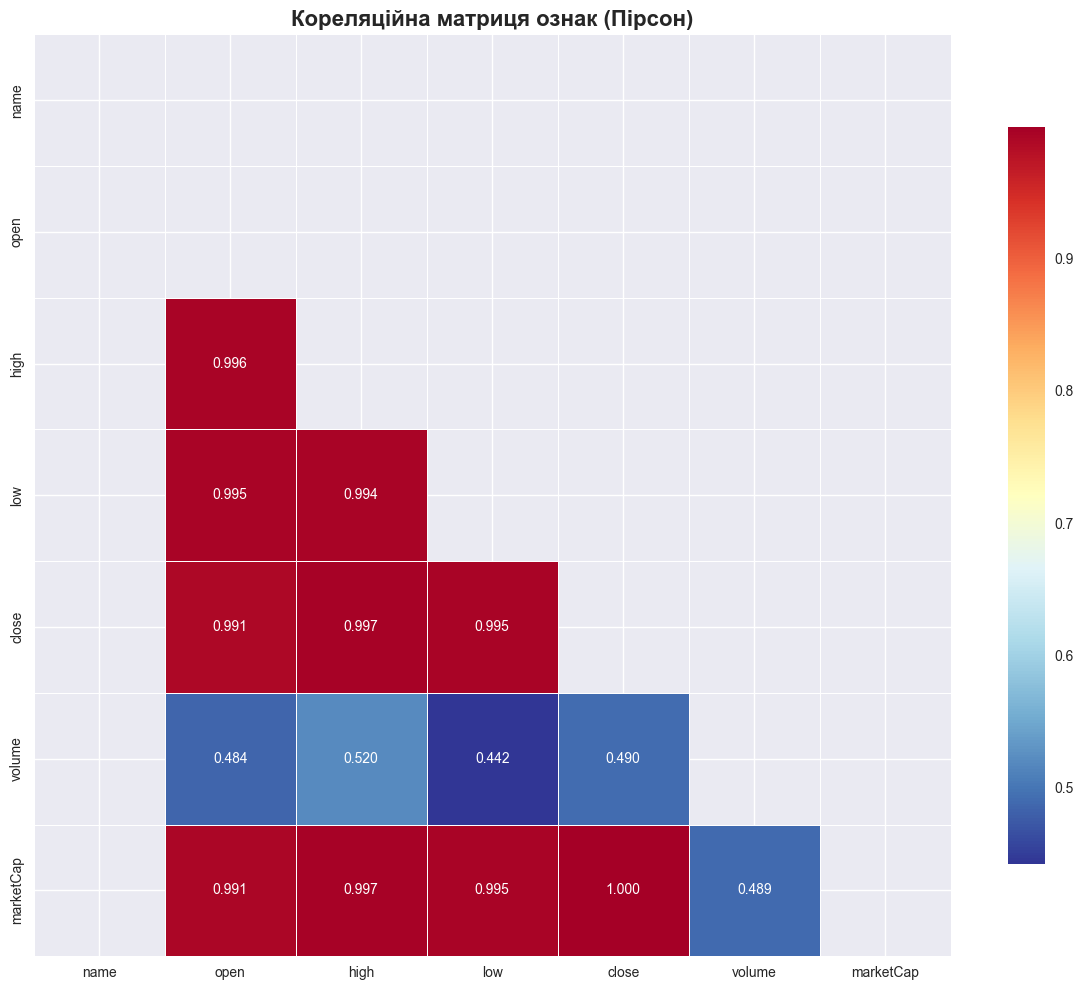


 Найсильніші кореляції:
 1. close        ↔ marketCap   :  1.000
 2. high         ↔ marketCap   :  0.997
 3. high         ↔ close       :  0.997
 4. open         ↔ high        :  0.996
 5. low          ↔ marketCap   :  0.995
 6. low          ↔ close       :  0.995
 7. open         ↔ low         :  0.995
 8. high         ↔ low         :  0.994
 9. open         ↔ marketCap   :  0.991
10. open         ↔ close       :  0.991

 РОЗПОДІЛ ОЗНАК


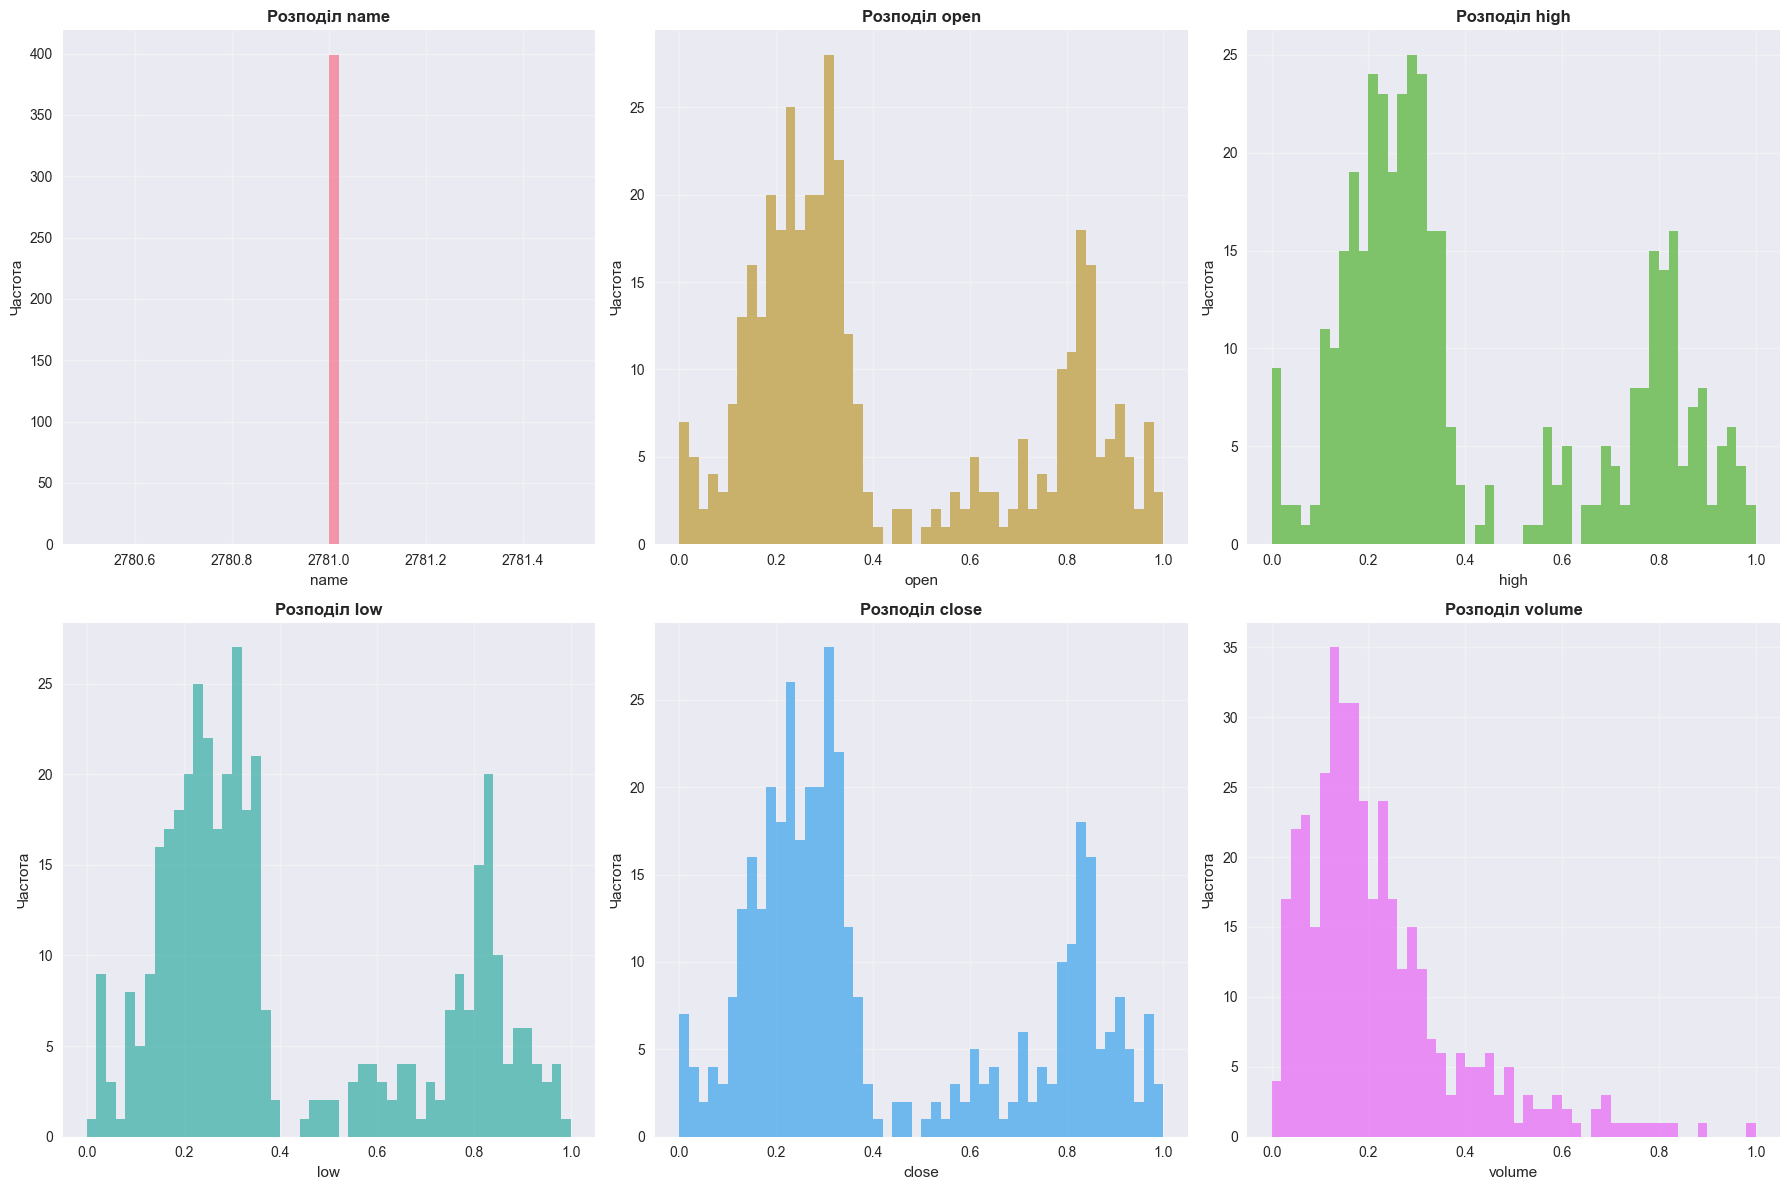


 ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ МОДЕЛІ: MLP_w15_h128_lr0.001_e1000
 МЕТРИКИ РЕГРЕСІЇ:
RMSE (Root Mean Square Error): 5424.6132
MAE (Mean Absolute Error): 3860.4596
MAPE (Mean Absolute Percentage Error): 6.61%
R² Score: 0.2187
Explained Variance Score: 0.4157


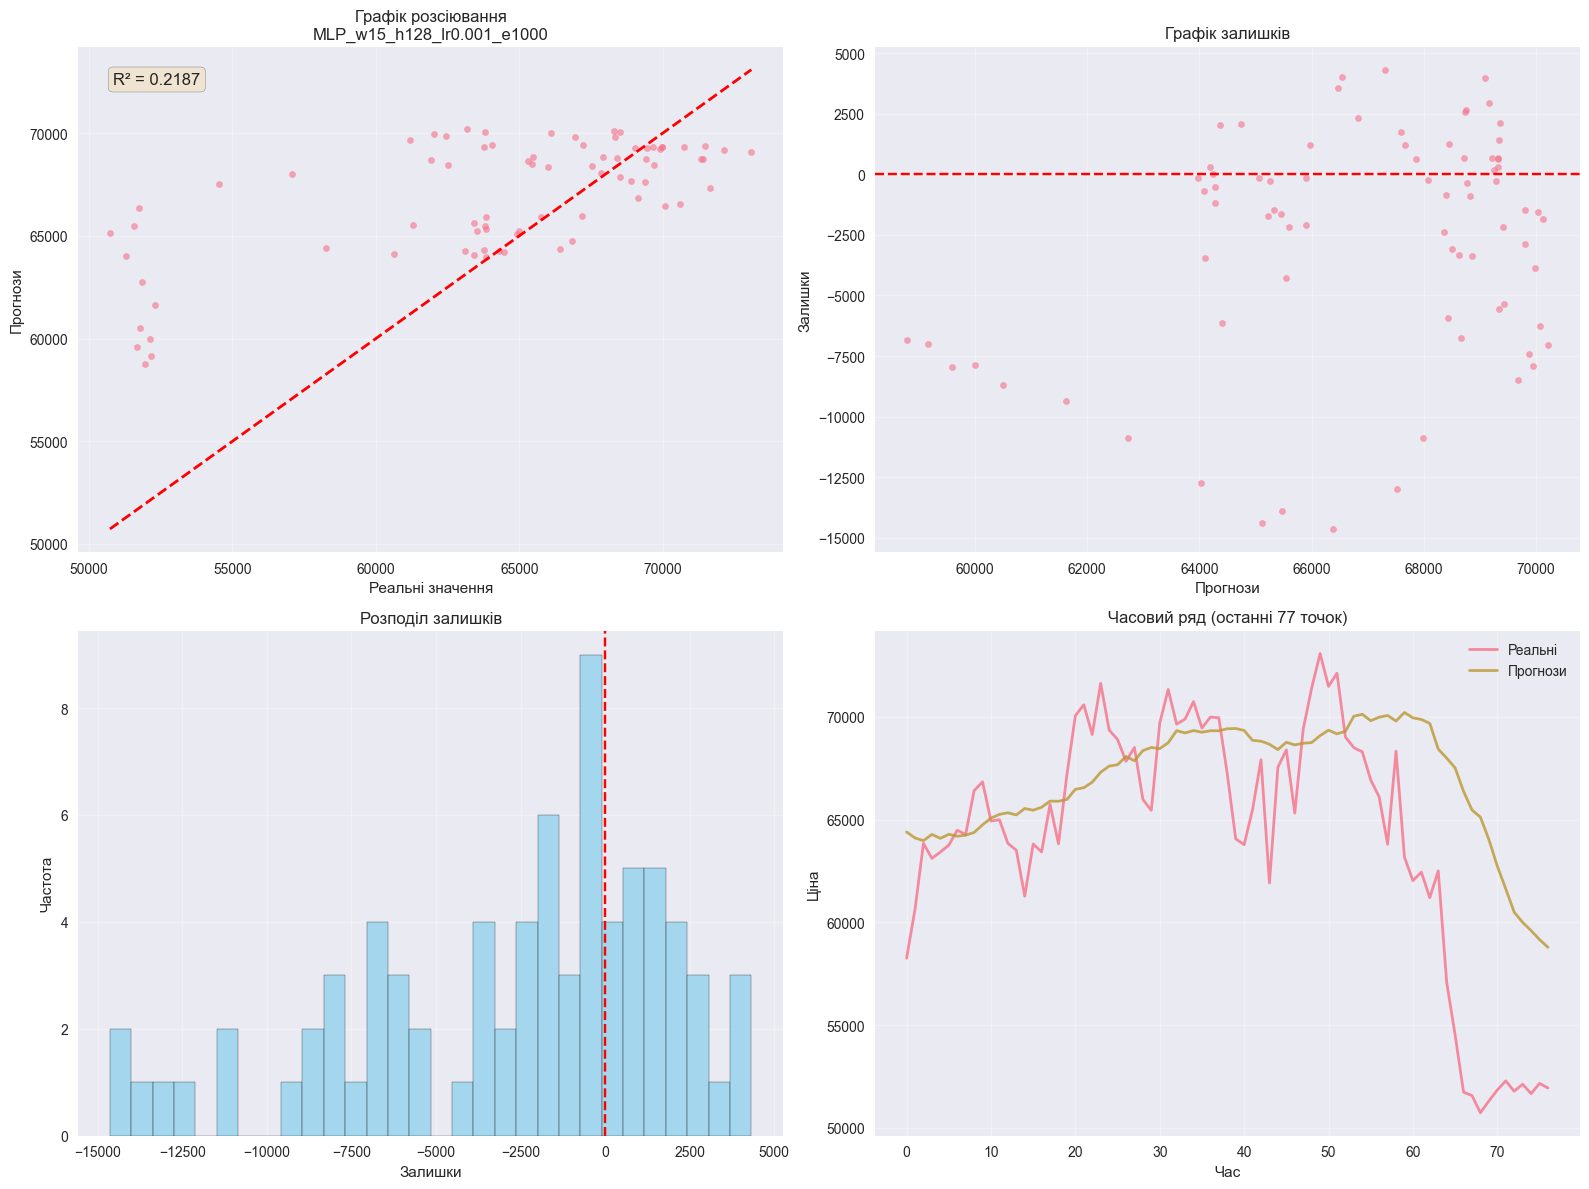


 КЛАСИФІКАЦІЙНІ МЕТРИКИ (Напрямок руху ціни):
Класи: 0 = Спадання, 1 = Зростання
Accuracy: 0.4474
Precision: 0.4488
Recall: 0.4474
F1-Score: 0.4478

 Детальний класифікаційний звіт:
              precision    recall  f1-score   support

    Спадання       0.47      0.45      0.46        40
   Зростання       0.42      0.44      0.43        36

    accuracy                           0.45        76
   macro avg       0.45      0.45      0.45        76
weighted avg       0.45      0.45      0.45        76



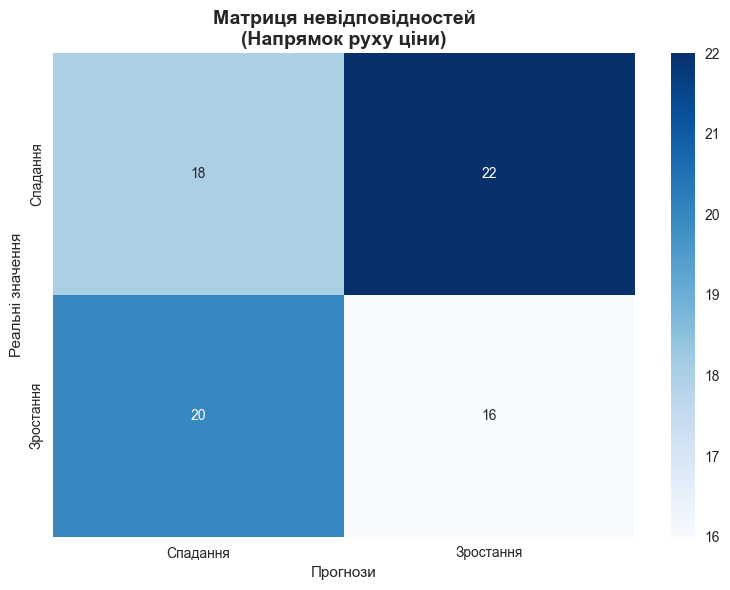


 Інтерпретація матриці невідповідностей:
True Negatives (правильно передбачені спадання): 18
False Positives (помилково передбачені зростання): 22
False Negatives (пропущені зростання): 20
True Positives (правильно передбачені зростання): 16

 ТАБЛИЦЯ ПОРІВНЯННЯ МЕТРИК:
Метрика      Значення   Опис                                    
-----------------------------------------------------------------
Accuracy     0.4474     Частка правильних прогнозів             
Precision    0.4488     Частка правильних позитивних прогнозів  
Recall       0.4474     Частка знайдених позитивних випадків    
F1-Score     0.4478     Гармонічне середнє Precision і Recall   


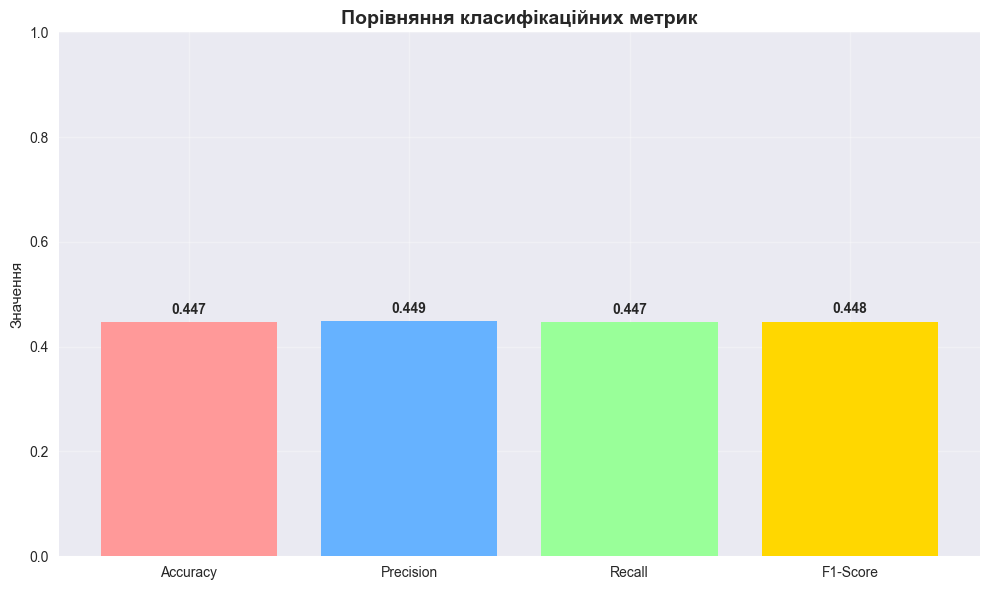


 АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
 Статистика параметрів моделі:
Загальна кількість параметрів: 11,777
Навчальні параметри: 11,777

 Статистика вхідних ознак:
       Feature       Mean     Std        Min        Max
0    Feature_0  2781.0000  0.0000  2781.0000  2781.0000
1    Feature_1     0.2722  0.0626     0.1357     0.4032
2    Feature_2     0.2751  0.0590     0.1407     0.3862
3    Feature_3     0.2655  0.0599     0.1323     0.3955
4    Feature_4     0.2000  0.1185     0.0283     0.6669
..         ...        ...     ...        ...        ...
85  Feature_85     0.2417  0.1108     0.0000     0.4032
86  Feature_86     0.2451  0.1090     0.0000     0.3862
87  Feature_87     0.2360  0.1028     0.0256     0.3955
88  Feature_88     0.2091  0.1262     0.0381     0.6669
89  Feature_89     0.2410  0.1071     0.0000     0.3977

[90 rows x 5 columns]

 АНАЛІЗ ЗАВЕРШЕНО!


In [ ]:
print("-" * 20)
print("ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ")
print("-" * 20)

best_model_name = sorted_results[0][0]

from ModelAnalyzer import ModelAnalyzer, run_complete_analysis

best_model_name = best_model[0]
model_results = best_model[1]
actual_pytorch_model = model_results['model']

test_data_X = model_results['X_test']
test_data_y = model_results['y_test']

analyzer, analysis_results = run_complete_analysis(
    df=scaled_df,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    best_model=actual_pytorch_model,
    X_test=test_data_X,
    y_test=test_data_y,
    model_name=best_model_name
)